# Assignment 2 Object Detection [Train]

Contains code for the custom dataloader, training and saving the model, and sample inference on test images.

## 1. Setup and import dependencies

Update torchvision and torch library due to some newly added features not currently available in the preset libraries. Install pycocotools for the vision reference code blocks.

In [1]:
!pip install torchvision -U
!pip install torch -U
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 587.5 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370027 sha256=caefd3813a8683b2bc845e9a2483763aea821c86cbf2ee1eb4208a39ad457843
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744

In [2]:
import torch
import numpy as np
import label_utils
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

Set config information.

**NOTE:** Modify the `dataset_dir` as necessary for your own training flow.

In [3]:
dataset_dir = "../input/drinks-dataset/drinks"
config = {
    "num_workers": 2,
    "pin_memory": True,
    "batch_size": 8,
    "dataset": "drinks",
    "train_split": f"{dataset_dir}/labels_train.csv",
    "test_split": f"{dataset_dir}/labels_test.csv",}

## 2. Create custom Drinks DataLoader

Modify the initial data loader class for the drinks dataset to conform with COCO.

Changes include:
- Separated entries of the dict to *boxes* and *labels*
- Order of the box coordinates (`[xmin, xmax, ymin, ymax]` -> `[xmin, ymin, xmax, ymax]`)
- Added *image_id*, *area*, *iscrowd* to the target values alongside boxes and labels
- Disregarded masking since the main problem to solve is image detection and not image segmentation
- Additionally, the labels were changed to Summit, Coke, and Pine Juice for the demo.

Changes were limited/restrained to the data loader (besides the config settings) instead of the label_utils to anticipate for other changes/data requirements for other models. This way, only the data loader is to be modified/updated for when new models with other formats are tested.

In [4]:
test_dict, test_classes = label_utils.build_label_dictionary(
    config['test_split'])
train_dict, train_classes = label_utils.build_label_dictionary(
    config['train_split'])

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dictionary, classes, transform=None):
        self.dictionary = dictionary
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.dictionary)

    def __getitem__(self, idx):
        """
        - boxes : Nx4
        - labels : N
        - image_id : 1
        - area : N // area of box
        - iscrowd : 1 // T/F
        optional: masks, keypoints
        """

        # retrieve the image filename
        key = list(self.dictionary.keys())[idx]
        # retrieve all bounding boxes
        boxes = self.dictionary[key]
        # open the file as a PIL image
        img = Image.open(key)
        # apply the necessary transforms
        # transforms like crop, resize, normalize, etc
        if self.transform:
            img = self.transform(img)
        
        # get other required info
        num_objs = len(boxes)

        # format of boxes is [boxes, label]; separate the tensors
        labels = boxes.T[-1]
        boxes = boxes.T[:-1].T

        # convert to torch tensors 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # since original box format is xmin, xmax, ymin, ymax
        # switch xmax and ymin col to follow COCO dataset format
        # xmin, ymin, xmax, ymax
        boxes = torch.index_select(boxes, 1, torch.LongTensor([0,2,1,3]))

        # set to target dict
        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

Sample code to check the format of the data. Used to confirm the shape and data within the dictionaries from the original source code.

In [5]:
# test_dict['../input/drinks-dataset/drinks/0010000.jpg']

# x = torch.as_tensor(test_dict['../input/drinks-dataset/drinks/0010000.jpg'], dtype=torch.float32)

# y = x.T[-1]
# x = x.T[:-1].T

# torch.as_tensor(test_dict['../input/drinks-dataset/drinks/0010000.jpg'], dtype=torch.float32).T[-1]

# targets[0]

In [6]:
# Use collate fn in https://github.com/pytorch/vision/blob/main/references/detection/utils.py
def collate_fn(batch):
    return tuple(zip(*batch))

train_split = ImageDataset(train_dict, train_classes, transforms.ToTensor())
test_split = ImageDataset(test_dict, test_classes, transforms.ToTensor())

# This is approx 95/5 split
print("Train split len:", len(train_split))
print("Test split len:", len(test_split))

train_loader = DataLoader(train_split,
                          batch_size=config['batch_size'],
                          shuffle=True,
                          num_workers=config['num_workers'],
                          pin_memory=config['pin_memory'],
                          collate_fn=collate_fn)

test_loader = DataLoader(test_split,
                         batch_size=config['batch_size'],
                         shuffle=False,
                         num_workers=config['num_workers'],
                         pin_memory=config['pin_memory'],
                         collate_fn=collate_fn)

Train split len: 996
Test split len: 51


## 3. Setup and train the model

In [7]:
!git clone https://github.com/pytorch/vision

Cloning into 'vision'...
remote: Enumerating objects: 128356, done.
remote: Counting objects: 100% (541/541), done.
remote: Compressing objects: 100% (508/508), done.
remote: Total 128356 (delta 497), reused 54 (delta 31), pack-reused 127815
Receiving objects: 100% (128356/128356), 249.38 MiB | 27.49 MiB/s, done.
Resolving deltas: 100% (112366/112366), done.


Change directory for easier importing and change back working directory afterwards to original setting.

In [8]:
import os
os.chdir("./vision/references/detection/")

from engine import train_one_epoch, evaluate
import utils

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

Adjusted some parameters throughout testing. It was found that metrics plateaued around higher epochs (e.g.16-20.)

In [11]:
num_classes = len(label_utils.params["classes"])

model = create_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0075,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

num_epochs = 15

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [12]:
os.chdir("/kaggle/working")

In [13]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)

Epoch: [0]  [  0/125]  eta: 0:04:05  lr: 0.000068  loss: 2.2001 (2.2001)  loss_classifier: 1.8280 (1.8280)  loss_box_reg: 0.3469 (0.3469)  loss_objectness: 0.0182 (0.0182)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 1.9621  data: 0.7982  max mem: 7771
Epoch: [0]  [ 10/125]  eta: 0:02:11  lr: 0.000672  loss: 1.6513 (1.5251)  loss_classifier: 1.2954 (1.1730)  loss_box_reg: 0.3184 (0.3236)  loss_objectness: 0.0208 (0.0216)  loss_rpn_box_reg: 0.0070 (0.0069)  time: 1.1418  data: 0.0729  max mem: 8034
Epoch: [0]  [ 20/125]  eta: 0:01:56  lr: 0.001276  loss: 0.8424 (1.1613)  loss_classifier: 0.4635 (0.8152)  loss_box_reg: 0.3116 (0.3203)  loss_objectness: 0.0186 (0.0194)  loss_rpn_box_reg: 0.0058 (0.0064)  time: 1.0685  data: 0.0004  max mem: 8034
Epoch: [0]  [ 30/125]  eta: 0:01:44  lr: 0.001881  loss: 0.6638 (0.9843)  loss_classifier: 0.3509 (0.6404)  loss_box_reg: 0.3136 (0.3195)  loss_objectness: 0.0152 (0.0185)  loss_rpn_box_reg: 0.0052 (0.0060)  time: 1.0698  data: 0.0004  max mem: 8034


## 4. Save the object detection model

In [14]:
import time

model_dir = f"{os.getcwd()}"
model_name = f"adulay-fasterrcnn_resnet50_fpn-{time.time()}"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(model.state_dict(), f"{model_dir}/{model_name}.pth")

In [15]:
import pickle
with open(f"{model_dir}/{model_name}.pkl", 'wb') as handle:
    pickle.dump(model, handle)

Use the following codeblock to generate download links in case the Output section on the Kaggle notebook is unresponsive.

In [17]:
!ls

__notebook_source__.ipynb
adulay-fasterrcnn_resnet50_fpn-1651304089.3776634.pkl
adulay-fasterrcnn_resnet50_fpn-1651304089.3776634.pth
vision


In [18]:
file = f"{model_dir}/{model_name}"
from IPython.display import FileLink
os.chdir(r'/kaggle/working')

In [19]:
# Note: change the time portion of the filename during the actual runtime
FileLink(r"adulay-fasterrcnn_resnet50_fpn-1651304089.3776634.pkl")

/kaggle/working/adulay-fasterrcnn_resnet50_fpn-1651304089.3776634.pkl

In [20]:
FileLink(r"adulay-fasterrcnn_resnet50_fpn-1651304089.3776634.pth")

/kaggle/working/adulay-fasterrcnn_resnet50_fpn-1651304089.3776634.pth

## 5. Sample Inference

Some functions were based on / references this [article by Sovit Ranjan Rath](https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/). Some changes were made to accomodate the flow and some fixes were done on the original code.

Since opencv2 windows does not work properly within Kaggle, a workaround for plotting the results is through matplotlib.

In [50]:
test_dict.keys()

dict_keys(['../input/drinks-dataset/drinks/0010000.jpg', '../input/drinks-dataset/drinks/0010001.jpg', '../input/drinks-dataset/drinks/0010002.jpg', '../input/drinks-dataset/drinks/0010003.jpg', '../input/drinks-dataset/drinks/0010004.jpg', '../input/drinks-dataset/drinks/0010005.jpg', '../input/drinks-dataset/drinks/0010006.jpg', '../input/drinks-dataset/drinks/0010007.jpg', '../input/drinks-dataset/drinks/0010008.jpg', '../input/drinks-dataset/drinks/0010009.jpg', '../input/drinks-dataset/drinks/0010010.jpg', '../input/drinks-dataset/drinks/0010011.jpg', '../input/drinks-dataset/drinks/0010012.jpg', '../input/drinks-dataset/drinks/0010013.jpg', '../input/drinks-dataset/drinks/0010014.jpg', '../input/drinks-dataset/drinks/0010015.jpg', '../input/drinks-dataset/drinks/0010016.jpg', '../input/drinks-dataset/drinks/0010017.jpg', '../input/drinks-dataset/drinks/0010018.jpg', '../input/drinks-dataset/drinks/0010019.jpg', '../input/drinks-dataset/drinks/0010020.jpg', '../input/drinks-datase

In [51]:
import sys
import cv2
import matplotlib.pyplot as plt

def preprocess_frame(image):
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)   
    return image

In [52]:
def detect_drinks(filename, detection_threshold=0.8):
    # lowest value found at around ~0.8, adjust to lower value to 'capture more'/higher allowance
    # default threshold set to 0.8 since 0.75 captures other objects in the background as drinks
    # setting to a higher value (e.g. 0.9) lowers those cases

    image = cv2.imread(filename)
    orig_image = image.copy()
    image = preprocess_frame(image)

    outputs = model(image)

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [label_utils.params["classes"][i] for i in outputs[0]['labels'].cpu().numpy()]

        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            cv2.putText(orig_image, pred_classes[j], 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                        2, lineType=cv2.LINE_AA)

        imgplot = plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
        plt.show()

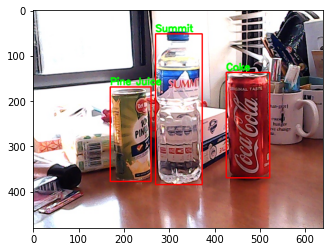

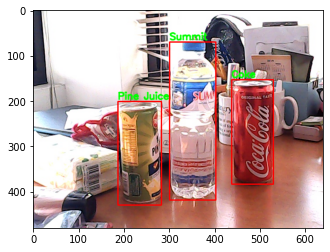

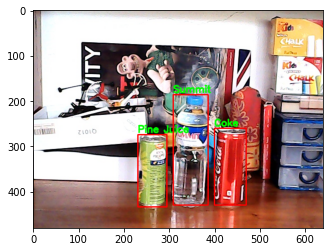

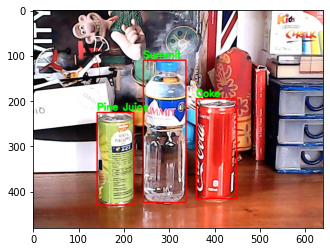

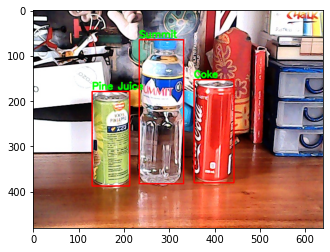

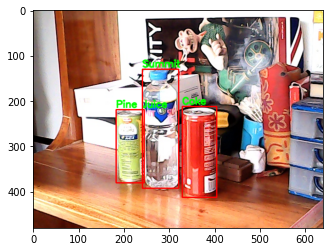

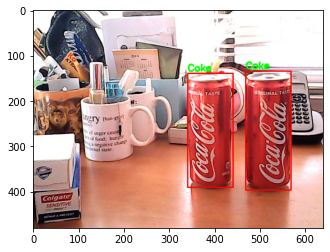

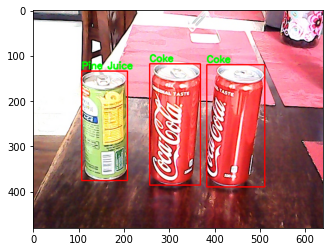

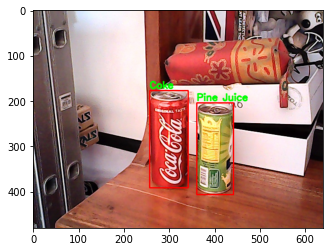

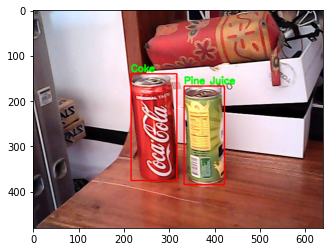

In [56]:
for filename in list(test_dict.keys())[:10]:
    detect_drinks(filename, detection_threshold=0.9)